# Classifying SNe

This notebook identifies SN91bg-like SNe and compares the results of photometric and spectroscopic classifications.

#### Table of Contents:
1. <a href='#reading_in_data'>Reading in the Data</a>: Reading in data from both the analysis pipeline and external publications.
1. <a href='#spectroscopic_classification'>Spectroscopic Classification</a>: Subtyping of spectroscopically observed targets.
1. <a href='#photometric_classification'>Photometric Classification</a>: Subtyping of Photometrically observed targets.
1. <a href='#intrinsic_properties'>Intrinsic Properties</a>: Plots of fitted parameters from the classification proccess.
1. <a href='#host_properties'>Host Galaxy Properties</a>: Identification of trends with host galaxy mass and SSFR.


In [1]:
import math
import sys
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
from astropy.table import Table
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.utils import resample
from sndata.csp import dr1
from sndata.sdss import sako18, sako18spec

sys.path.insert(0, '../')
from phot_class import spectra as spec_class

dr1.download_module_data()
sako18spec.download_module_data()
sako18.download_module_data()

# Output directory for figures
fig_dir = Path('./notebook_figs/classification')
fig_dir.mkdir(exist_ok=True, parents=True)
results_dir = Path('../results/').resolve()


## Reading in the Data <a id='reading_in_data'></a>

To save time later on, we read in all of the necessary data in advance. We start with spectroscopic measurements and classifications from external publications. This will allow us to perform a sanity check on our results.


In [2]:
# Read in sdss classifications
sdss_master = sako18.load_table('master')
sako_classification = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'spec_class': sdss_master['Classification']
})
sako_classification.set_index('obj_id', inplace=True)
sako_classification.head()


,spec_class
obj_id,
679,Unknown
680,Variable
682,Unknown
685,pSNII
688,Unknown


In [3]:
folatelli_13 = dr1.load_table(6).to_pandas()
branch_06 = pd.DataFrame({
    'obj_id': ['1981B', '1984A', '1986G', '1989B', '1990N', '1991M', '1991T', '1991bg', '1992A', '1994D', '1194ae', '1996X', '1997cn', '1998ag', '1998bu', '1999aw', '1999by', '1999ee', '2000cx', '2001ay', '2001el', '2002bf', '2002bo', '2002cx'],
    'pw7': [127, 204, 126, 124, 88, 137, 29, 92, 107, 96, 89, 87, 101, 78, 94, 58, 95, 82, 51, 150, 95, 171, 146, 18 ],
    'pw6': [17, 23, 33, 20, 12, 19, 0, 49, 19, 19, 7, 17, 45, 12, 16, 1, 46, 5, 2, 8, 16, 10, 11, 0]
})

branch_06.set_index('obj_id', inplace=True)
branch_06.head()


,pw7,pw6
obj_id,,
1981B,127,17
1984A,204,23
1986G,126,33
1989B,124,20
1990N,88,12


Next we read in spectroscopic measurements from our own analysis pipeline.

In [4]:
@np.vectorize
def calc_julian_date(date):
    """
    Convert a datetime object into julian float.
    
    Args:
        date (str): The date to convert in %Y-%m-%d format

    Returns:
        The Julian date as a float
    """

    
    date = datetime.strptime(date, '%Y-%m-%d')
    julian_datetime = (
        367 * date.year - 
        int((7 * (date.year + int((date.month + 9) / 12.0))) / 4.0) + 
        int((275 * date.month) / 9.0) + date.day + 
        1721013.5 + 
        (date.hour + date.minute / 60.0 + date.second / math.pow(60, 2)) / 24.0 - 
        0.5 * math.copysign(1, 100 * date.year + date.month - 190002.5) + 0.5
    )

    return julian_datetime


def read_spec_results(path):
    """Read in spectroscopic measurements from the analysis pipeline
    
    Args:
        path (str): The path of the ecsv file to read
        
    Returns:
        A Pandas DataFrame
    """

    # Read in pipeline results
    spec_class = Table.read(path).to_pandas()
    spec_class.set_index(['obj_id', 'feat_name'], inplace=True)
    spec_class['jd'] = calc_julian_date(spec_class.date)
    
    # Get time of peak brightness
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        master = sako18spec.load_table('master').to_pandas()
        master = master.rename(columns={'CID': 'obj_id'}).set_index('obj_id')

    # Calculate days since maximum
    peak_jd = master.MJDatPeakrmag + 2400000.5
    spec_class['days'] = spec_class.jd - peak_jd
    
    return spec_class


In [5]:
spec_results = read_spec_results(results_dir / 'spec_class/sdss_sako18spec_rv3_1_bin5.0_methgauss_step5.ecsv')
spec_results.head()


sid        date type   feat_start     feat_end          vel  \
obj_id feat_name                                                                
10096  pW6        532  2005-11-26   Ia  5651.188287  5885.087746  7607.291965   
       pW7        532  2005-11-26   Ia  5885.087746  6319.151164  8571.577006   
10434  pW6        505  2005-11-24   Ia  5641.615828  5970.899193  8523.125785   
       pW7        505  2005-11-24   Ia  5970.899193  6401.162790  8844.113772   
10449  pW6        546  2005-11-27   Ia  5637.199557  5935.511967  9200.152933   

                  vel_err  vel_samperr         pew  pew_err  pew_samperr  \
obj_id feat_name                                                           
10096  pW6            0.0          0.0    9.380641      0.0     1.227595   
       pW7            0.0          0.0   38.481348      0.0     2.441780   
10434  pW6            0.0          0.0   33.706916      0.0     1.571334   
       pW7            0.0          0.0  109.149294      0.0     1.549806   
10449  pW6            0.0          0.0   38.070610      0.0     2.394384   

                          area  area_err  area_samperr  msg         jd  days  
obj_id feat_name                                                              
10096  pW6        8.603847e-16       0.0  1.177297e-16  NaN  2453700.5   6.7  
       pW7        3.602614e-15       0.0  2.480661e-16  NaN  2453700.5   6.7  
10434  pW6        3.364003e-15       0.0  1.736317e-16  NaN  2453698.5  -2.1  
       pW7        9.817424e-15       0.0  1.869127e-16  NaN  2453698.5  -2.1  
10449  pW6        2.593038e-16       0.0  1.848175e-17  NaN  2453701.5   0.8

Finally, we read in the photometric classifications from our pipeline. We included data using band-by-band and collective fitting methods. We also include fit results from `iminuit` and `emcee`. This may take a minute since the `classify_targets` function isn't very well optimized.

In [6]:
from phot_class.classification import classify_targets

mcmc_coll_fits = Table.read('../results/collective_fits/with_ext/sdss_sako18_mcmc_fit_fits.ecsv')
mcmc_coll_class = classify_targets(mcmc_coll_fits).to_pandas().set_index(['obj_id'])
mcmc_coll_fits = mcmc_coll_fits.to_pandas().set_index(['source', 'obj_id'])

mcmc_band_fits = Table.read('../results/band_fits/with_ext/sdss_sako18_mcmc_fit_fits.ecsv')
mcmc_band_class = classify_targets(mcmc_band_fits).to_pandas().set_index(['obj_id'])
mcmc_band_fits = mcmc_band_fits.to_pandas().set_index(['source', 'obj_id'])

iminuit_coll_fits = Table.read('../results/collective_fits/with_ext/sdss_sako18_simple_fit_fits.ecsv')
iminuit_coll_class = classify_targets(iminuit_coll_fits).to_pandas().set_index(['obj_id'])
iminuit_coll_fits = iminuit_coll_fits.to_pandas().set_index(['source', 'obj_id'])

iminuit_band_fits = Table.read('../results/band_fits/with_ext/sdss_sako18_simple_fit_fits.ecsv')
iminuit_band_class = classify_targets(iminuit_band_fits).to_pandas().set_index(['obj_id'])
iminuit_band_fits = iminuit_band_fits.to_pandas().set_index(['source', 'obj_id'])

iminuit_band_fits.head()


/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:4: TableReplaceWarning: converted column 'pre_max' from integer to float
  after removing the cwd from sys.path.
/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:4: TableReplaceWarning: converted column 'post_max' from integer to float
  after removing the cwd from sys.path.
/anaconda3/envs/phot_class/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'pre_max' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/envs/phot_class/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'post_max' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:8: TableReplaceWarning: converted column 'pre_max' from integer to float
  
/anaconda3/envs/phot_class/lib/py

message            band  pre_max  \
source   obj_id                                                               
hsiao_x1 10028   Minimization exited successfully.             all     85.0   
         10028   Minimization exited successfully.  sdss_sako18_g4     17.0   
         10028   Minimization exited successfully.  sdss_sako18_i4     17.0   
         10028   Minimization exited successfully.  sdss_sako18_r4     17.0   
         10028   Minimization exited successfully.  sdss_sako18_u4     17.0   

                 post_max          vparams     mwebv         z  amplitude  \
source   obj_id                                                             
hsiao_x1 10028       20.0  t0,amplitude,x1  0.021712  0.064256   0.000219   
         10028        4.0     amplitude,x1  0.021712  0.064256   0.000212   
         10028        4.0     amplitude,x1  0.021712  0.064256   0.000237   
         10028        4.0     amplitude,x1  0.021712  0.064256   0.000223   
         10028        4.0     amplitude,x1  0.021712  0.064256   0.000209   

                           t0        x1  ...  mwebv_err  z_err  amplitude_err  \
source   obj_id                          ...                                    
hsiao_x1 10028   2.453694e+06 -0.141844  ...        NaN    NaN   7.311878e-07   
         10028   2.453694e+06 -0.134201  ...        NaN    NaN   8.785449e-07   
         10028   2.453694e+06 -0.109513  ...        NaN    NaN   1.762427e-06   
         10028   2.453694e+06 -0.107367  ...        NaN    NaN   9.081427e-07   
         10028   2.453694e+06 -0.225185  ...        NaN    NaN   3.735375e-06   

                  t0_err    x1_err  c_err   chisq  ndof  b_max  delta_15  
source   obj_id                                                           
hsiao_x1 10028   0.08593  0.006495    NaN  412.58  32.0 -19.16     1.330  
         10028       NaN  0.007464    NaN    9.06   5.0 -19.09     1.312  
         10028       NaN  0.017644    NaN   32.54   5.0 -19.33     1.258  
         10028       NaN  0.011104    NaN   44.56   5.0 -19.20     1.253  
         10028       NaN  0.026010    NaN    2.56   5.0 -19.06     1.544  

[5 rows x 21 columns]

## Spectroscopic Classification <a id='spectroscopic_classification'></a>

This section assigns Branch et al. 2006 style subtypes to SDSS spectra. This classification scheme relies on the pseudo equivalent width (pEW) of Si ii at λ5972 vs λ6355 (here-in refered to as features pW6 and pW7)

#### Section Contents:
1. <a href='#spectral_binning'>Spectral Binning</a>: A reminder of some of the manipulations performed on each spectrum during the analysis.
1. <a href='#selecting_good_data'>Selecting the "Good" Data</a>: Selects only measurements near peak brightness and drops results from noisy spectra.
1. <a href='#branch'>Branch Classification Plot</a>: Plots Si ii λ5972 vs Si ii λ6355 and assigns subtypes to each SN.

### Spectral Binning <a id='spectral_binning'></a>

We pause for a moment and remind ourselves that the values we are working with in this notebook are calculated after each spectra is restframed, corrected for Milky Way extinction, and binned to a resolution of five (unless otherwise noted) angstroms. We choose to use a gaussian filter to reduce the resolution, although options are available for averaging and summing in each bin using the `method` argument.


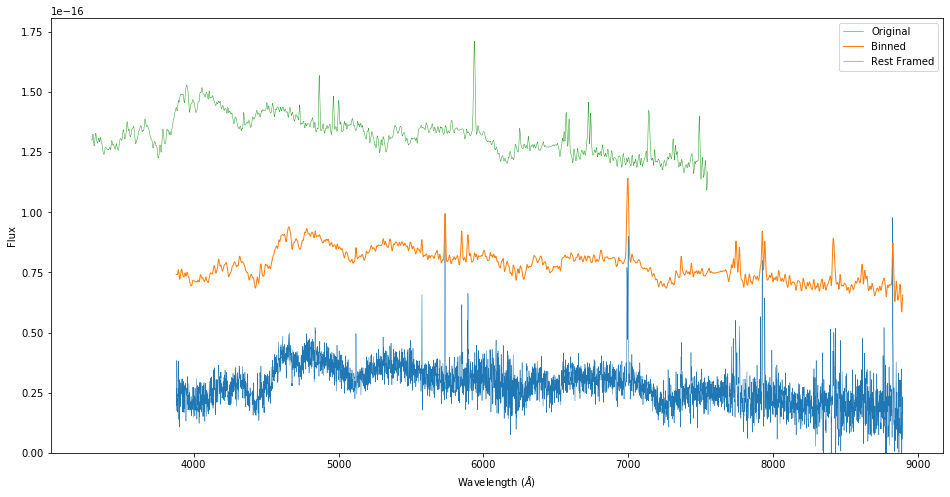

In [7]:
data = sako18spec.get_data_for_id('5635')
wave = data['wavelength']
flux = data['flux']
z = data.meta['z']
ra = data.meta['ra']
dec = data.meta['dec']

# Bin the flux and calculate the average in each bin
bin_wave, bin_flux = spec_class.bin_spectrum(wave, flux, method='gauss')

# Correct for exctinction and shift to rest frame
rest_wave, rest_flux = spec_class.correct_extinction(bin_wave, bin_flux, ra, dec, z)

plt.figure(figsize=(16, 8))
plt.plot(wave, flux, linewidth=.5, label='Original')
plt.plot(bin_wave, bin_flux + 5e-17, linewidth=1, label='Binned')
plt.plot(rest_wave, rest_flux + 1e-16, linewidth=.5, label='Rest Framed')

plt.ylim(ymin=0)
plt.ylabel('Flux')
plt.xlabel(r'Wavelength ($\AA$)')
plt.legend()


### Selecting the "Good" Data <a id='selecting_good_data'></a>

We start by checking the reasons why some of our calculations failed. Note that range and index related errors are user generated errors during the analysis used to indicate cases where the spectrum was too noisy to identify the feature.



In [8]:
spec_results[spec_results.pew.isna()].msg.value_counts()


Range too small. Please select a wider range        148
Feature not in spectral wavelength range.            13
index -1 is out of bounds for axis 0 with size 0      3
Name: msg, dtype: int64

We also check the number of observations available for each target. The data release includes targets with multiple observations, however, depending on how the analysis pipeline was run, duplicate observations may have already been dropped.

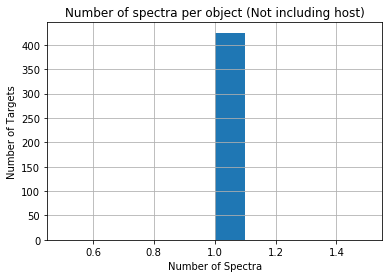

In [9]:
# Divide by two since there are two feature measurments per object.
(spec_results.sid.value_counts() / 2).hist()
plt.title('Number of spectra per object (Not including host)')
plt.ylabel('Number of Targets')
plt.xlabel('Number of Spectra')
plt.show()


Moving forward we drop results from spectra that:
1. Are not measured from the spectrum taken closest to peak brightness.
1. Do not have pW7 measurements due to their spectral range.
1. Fail visual inspection

We start with the first two conditions:

In [10]:
def get_tmax_pew(spec_data):
    """Keep only pew measurements performed nearest tmax
    
    Args:
        spec_data (DataFrame): Measurements from the analysis pipeline
    
    Returns:
        A pandas DataFrame
    """
    
    # Determine what features were measured
    features = spec_data.index.get_level_values('feat_name').unique()

    data_frames = []
    for feat_name in features:
        feat_data = spec_data.xs(feat_name, level='feat_name')
        feat_data['feat_name'] = feat_name
        feat_data.set_index('feat_name', append=True, inplace=True)
        
        feat_data['sort'] = feat_data.days.abs()         
        feat_data = feat_data.sort_values(by='sort')
        feat_data = feat_data[~feat_data.index.duplicated()]
        feat_data = feat_data.drop(axis=1, labels='sort')
        data_frames.append(feat_data)
    
    all_data = pd.concat(data_frames)
    all_data.dropna(subset=['pew'], inplace=True)
    
    return all_data.loc[all_data.xs('pW7', level='feat_name').index]


In [11]:
spec_results_peak = get_tmax_pew(spec_results)
spec_results_peak.head()


/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,,sid,date,type,feat_start,feat_end,vel,vel_err,vel_samperr,pew,pew_err,pew_samperr,area,area_err,area_samperr,msg,jd,days
obj_id,feat_name,,,,,,,,,,,,,,,,,
2031,pW6,118,2005-09-23,Ia,5669.537090,5879.242357,8491.982629,0.0,0.0,16.014189,0.0,1.000130,1.437390e-15,0.0,9.714634e-17,NaN,2453636.5,-0.1
5533,pW6,340,2005-10-26,Ia,5665.186791,5964.438710,8210.772047,0.0,0.0,25.734454,0.0,3.051258,2.359357e-16,0.0,3.035111e-17,NaN,2453669.5,-0.1
6315,pW6,365,2005-11-01,Ia,5652.170330,5990.646833,0.000000,0.0,0.0,20.997087,0.0,14.962084,3.054108e-16,0.0,2.203449e-16,NaN,2453675.5,-0.1
15459,pW6,1144,2006-10-23,Ia,5607.122569,6006.833222,6934.809923,0.0,0.0,24.460329,0.0,5.771620,7.169098e-16,0.0,1.812333e-16,NaN,2454031.5,-0.2
1241,pW6,112,2005-09-23,Ia,5565.941888,5996.766721,9908.257306,0.0,0.0,55.553342,0.0,2.870134,3.424053e-15,0.0,2.035423e-16,NaN,2453636.5,-0.2


Next we perform a visual inspection to drop results from any spectra that are particularly noisy. The analysis pipeline already requires the visual inspection of each spectrum, and many noisy spectra may have already been flagged and skipped over. However, the goal of the initial inspection is to be overly ambitious in what we can measure while acknowledging a secondary cut is required later on. We perform that cut here. We also drop spectra with H$\alpha$ lines, since that indicates a potential problem with the host galaxy subtraction.

The following few cells will plot each spectra and ask for an input. Valid inputs are as follows:
1. `<Enter>` indicates a good spectrum. 
1. A number replots the spectrum with a new upper bound
1. `n` Means the spectrum is too noisy.
1. `h` Indicates a strong H-alpha line
1. `r` Indicates the spectrum does not cover enough of the necessary wavelength range.

The `start_from` variable can be used to start the iteration process from a given object Id. Results generated by the notebook author are hardcoded below.

In [12]:
def subplot_feature_pew(wave, flux, axis, feat_start, feat_end):
    """Shade in the PEW of spectral properties

    Args:
        wave (ndarray): The spectrum's wavelengths
        flux (ndarray): The flux for each wavelength
        axis    (Axis): The axius to plot on
    """

    idx_start = np.where(wave == feat_start)[0][0]
    idx_end = np.where(wave == feat_end)[0][0]
    feat_wave = wave[idx_start: idx_end + 1]
    feat_flux = flux[idx_start: idx_end + 1]

    continuum, norm_flux, pew = spec_class.feature_pew(feat_wave, feat_flux)
    axis.plot(feat_wave, continuum, color='C1', linestyle='--')
    axis.fill_between(feat_wave, feat_flux, continuum, color='C1', alpha=.5, zorder=0)


def subplot_feature_bounds(axis):
    """Plot the blue and red boundaries used for each feature

    Args:
        axis (Axis): The axis to plot on
    """

    color = 'C0'
    alpha = 1

    pw6 = spec_class.line_locations['pW6']
    axis.axvline(pw6['lower_blue'], color=color, linestyle='-.', alpha=alpha)
    axis.axvline(pw6['upper_blue'], color=color, linestyle=':', alpha=alpha)
    axis.axvline(pw6['lower_red'], color=color, linestyle='-.', alpha=alpha)
    axis.axvline(pw6['upper_red'], color=color, linestyle=':', alpha=alpha)

    pw7 = spec_class.line_locations['pW7']
    axis.axvline(pw7['lower_red'], color=color, linestyle='-.', alpha=alpha)
    axis.axvline(pw7['upper_red'], color=color, linestyle=':', alpha=alpha)


def plot_outliers(outlier_data):
    """Plot a collection of spectra

    Args:
        outlier_data (DataFrame): PEW Measurements for spectra to plot

    Returns:
        A matplotlib Figure
        An array of matplotlib axes
    """

    obj_ids = outlier_data.index.get_level_values('obj_id').unique()
    fig, axes = plt.subplots(len(obj_ids), 1, figsize=(15, 4 * len(obj_ids)), sharex=True)
    axes = np.atleast_1d(axes)

    for obj_id, axis in zip(obj_ids, axes):
        target_data = sako18spec.get_data_for_id(obj_id)
        target_data.sort('wavelength')

        # Keep only the SN spectra used in the classification
        date = outlier_data.loc[obj_id].date[0]
        pw6_pew = outlier_data.loc[obj_id, 'pW6'].pew
        pw7_pew = outlier_data.loc[obj_id, 'pW7'].pew

        target_data = target_data[target_data['date'] == date]
        target_data = target_data[target_data['type'] != 'Gal']

        # Correct for exctinction and shift to rest frame
        wave = target_data['wavelength']
        flux = target_data['flux']
        z = target_data.meta['z']
        ra = target_data.meta['ra']
        dec = target_data.meta['dec']
        rest_wave, rest_flux = spec_class.correct_extinction(wave, flux, ra, dec, z)
        bin_wave, bin_flux = spec_class.bin_spectrum(rest_wave, rest_flux, method='gauss')

        axis.plot(rest_wave, rest_flux, lw=1, label='Restframed', color='grey',
                  alpha=.75)
        for _, row in outlier_data.loc[obj_id].iterrows():
            subplot_feature_pew(bin_wave, bin_flux, axis, row.feat_start,
                                row.feat_end)
            subplot_feature_bounds(axis)

        axis.plot(bin_wave, bin_flux, lw=2, label='Binned', color='k')
        axis.set_xlabel('Wavelength')
        axis.set_ylabel('Flux')
        axis.set_ylim(0, 3e-17)
        axis.set_title(f'Obj Id: {obj_id}')
        axis.legend()

    axis.set_xlim(3000, 7500)

    return fig, axes


In [13]:
ha = []
noisy = []
bad_range = []

# '99999' is higher than any object Id, thus skipping the analysis process described above.
start_from = '99999'  


In [14]:
from IPython.display import clear_output


indices = spec_results_peak.index.get_level_values('obj_id').unique()
for i, idx in enumerate(sorted(indices)):
    if idx < start_from:
        continue
        
    inp = '5e-17'    
    while inp:
        if inp == 'h':
            ha.append(idx)
            break
            
        if inp == 'n':
            noisy.append(idx)
            break
            
        if inp == 'r':
            bad_range.append(idx)
            break
            
        clear_output()
        f, a = plot_outliers(spec_results_peak.loc[[idx]])
        a[0].set_ylim(0, float(inp))
        plt.show()
        inp = input(f'{i}/{len(indices)} ({i / len(indices) * 100:.2f}%)')
    
    last_index = idx
    clear_output()
 

Here are results tabulated by the notebook author.

In [15]:
ha = [
    '10096', '10805', '12844', '12856', '12874', '12927', '12950', '12977', 
    '13025', '13070', '13099', '13152', '13174', '13254', '13354', '13467', 
    '13830', '14261', '14279', '15129', '15136', '15213', '15234', '15467', 
    '16099', '16099', '16578', '16637', '16692', '16776', '16847', '17176', 
    '17220', '17389', '17568', '17605', '18375', '18485', '18697', '18903', 
    '19003', '19008', '19207', '19353', '19626', '19775', '19969', '20142', 
    '20245', '20528', '21062', '2330', '2635', '2789', '3901', '4524', '5717', 
    '5751', '6057', '6108', '6249', '6773', '7876', '8921'
]

noisy = [
    '11067', '11300', '11452', '11557', '1166', '13610', '13655', '13689', 
    '13736', '14421', '15203', '15229', '15287', '15356', '15383', '15456', 
    '16072', '16350', '16414', '16789', '17048', '18749', '18855', '18890', 
    '18927', '18959', '19230', '20106', '20144', '20184', '20227', '20345', 
    '20432', '20581', '20768', '21034', '21510', '2372', '2533', '2689', '3080', 
    '3199', '3452', '4577', '4679', '6127', '6137', '744', '7475', '7512', '762', 
    '774', '7947', '8598', '9457', '7143'
]

bad_range = ['16116', '17171', '17208', '17215', '19616', '19658']


In [16]:
bad_obj_ids = set(ha + noisy + bad_range)
good_spectra = spec_results_peak.drop(bad_obj_ids)
print(f'{len(bad_obj_ids)} bad spectra out of {len(spec_results_peak.index.unique())}')


/Users/daniel/.local/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


125 bad spectra out of 584


In [17]:
def plot_all_spectra(
        spec_measurements, xlim=(5000, 7000), space_scale=1.5, num_columns=2):
    """Plot all spectra used in our data sample with PEW above a given SNR

    Args:
        spec_measurements: 
        xlim: 
        space_scale: 
        num_columns: 

    Returns:
        A matplotlib figure
        A matplotlib axis
    """

    fig, axes = plt.subplots(1, num_columns, figsize=(8.5, 11), sharex=True)

    # Divide object ids into sperate collections for each figure columns
    spec_to_plot = list(spec_measurements.index.get_level_values('obj_id').unique())
    spec_per_col = int(np.ceil(len(spec_to_plot) / num_columns))
    spectra_cols = [spec_to_plot[i * spec_per_col: (i + 1) * spec_per_col] for i in range(num_columns)]
    
    for obj_ids_in_column, axis in zip(spectra_cols, axes.flatten()):
        
        yticks = []
        for i, obj_id in enumerate(obj_ids_in_column):
            target_data = sako18spec.get_data_for_id(obj_id)
            target_measurements = spec_measurements.loc[obj_id]
            offset = i * space_scale

            # Keep only the SN spectra used in the classification
            date = target_measurements.date[0]
            target_data = target_data[target_data['date'] == date]
            target_data = target_data[target_data['type'] != 'Gal']

            # Correct for extinction, shift to rest frame, and bin spectrum
            wave = target_data['wavelength']
            flux = target_data['flux']
            z = target_data.meta['z']
            ra = target_data.meta['ra']
            dec = target_data.meta['dec']

            bin_wave, bin_flux = spec_class.bin_spectrum(wave, flux)
            rest_wave, rest_flux = spec_class.correct_extinction(
                bin_wave, bin_flux, ra, dec, z)

            # Scale and offset spectra to same order of magnitude
            _, pw7_end = spec_class.guess_feature_bounds(
                rest_wave, rest_flux, spec_class.line_locations['pW7'])

            scale = rest_flux[np.where(rest_wave == pw7_end)[0][0]]
            rest_flux /= scale
            rest_flux += offset

            axis.plot(rest_wave, rest_flux, lw=1, color='k')
#             subplot_feature_pew(rest_wave, rest_flux, axis)
            
            min_idx = np.argmin(abs(rest_wave - xlim[0]))
            yticks.append(rest_flux[min_idx])

        axis.set_ylim(0, (i + 1) * space_scale)
        axis.set_yticks(yticks)
        axis.set_yticklabels(obj_ids_in_column)
        axis.set_xlim(xlim)

        axis.set_xlabel('Wavelength')

    axes[0].set_ylabel('Candidate Id')
    plt.tight_layout()


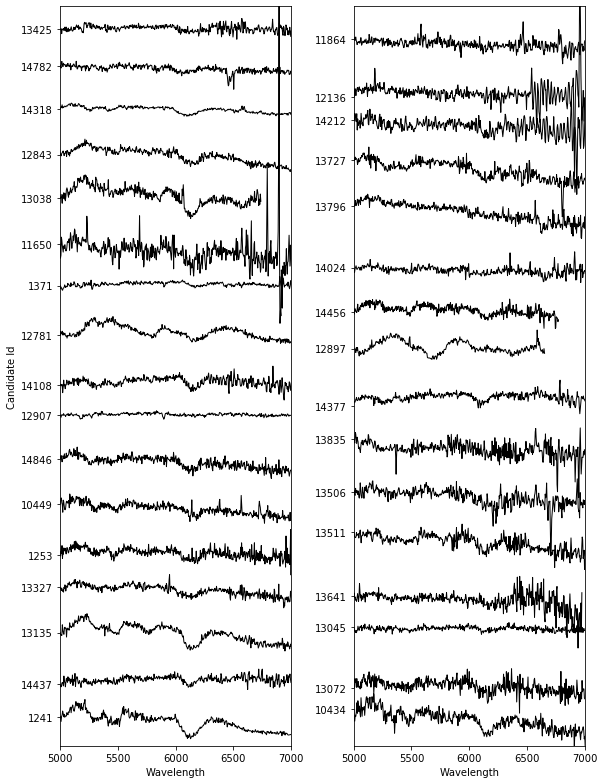

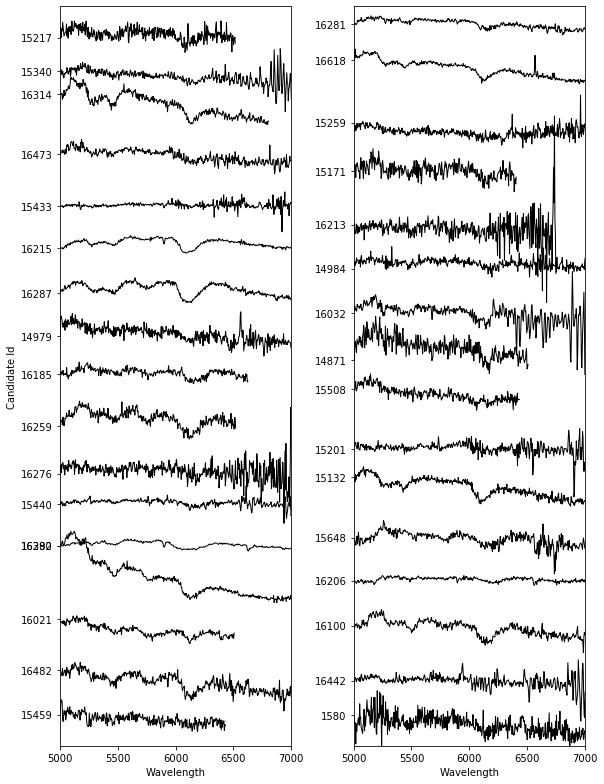

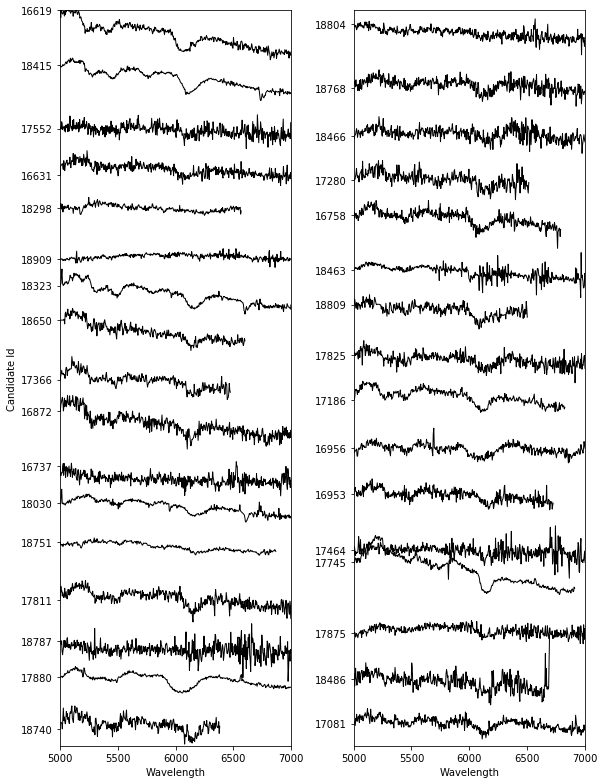

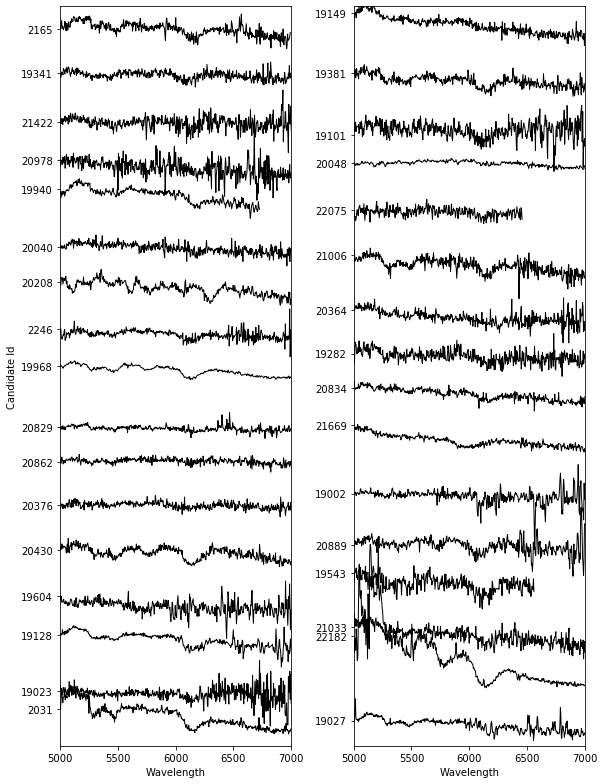

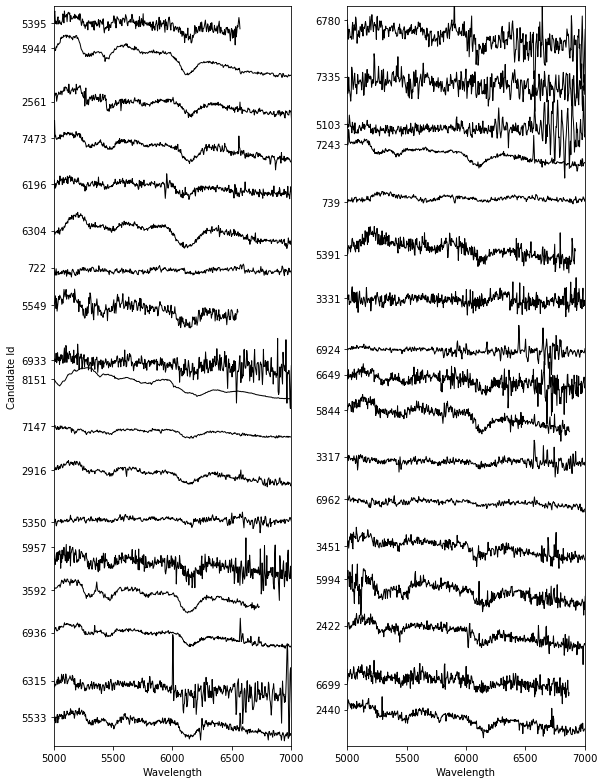

In [18]:
obj_ids = sorted(good_spectra.index.get_level_values('obj_id').unique())

num_figs = 5
for i in range(num_figs - 1):
    n = len(obj_ids) // num_figs
    fig_ids = obj_ids[i * n: (i + 1) * n]
    plot_all_spectra(spec_results_peak.loc[fig_ids])
    plt.show()

fig_ids = obj_ids[(i + 1) * n:]
plot_all_spectra(spec_results_peak.loc[fig_ids])
plt.show()


### Branch Classification Plot <a id='branch'></a>

We plot the pEW of Si ii at λ5972 vs λ6355. 


In [19]:
def get_colors(pw6, pw7):
    """Get the color of each point bassed on its coordinates
    
    Args:
        pw6 (ndarray): Array of EW measurements for feature 6
        pw7 (ndarray): Array of EW measurements for feature 7
        
    Returns:
        A 2d array of RGB values
    """
    
    color = np.empty(len(pw6), dtype='U10')
    color[:] = 'black'  # Default to black
    color[pw6 > 30] = 'blue'  # Blue
    color[(pw6 < 30) & (pw7 > 105)] = 'red'  # Red
    color[pw7 < 70] = 'green'  # Green

    return color

def subplot_published_classes(axis):
    """Plot Si ii pEW at λ5972 vs λ6355 from CSP and Branch 2006
    
    Args:
        axis (Axis): A matplotlib axis
    """

    axis.scatter(
        branch_06.pw7, 
        branch_06.pw6, 
        marker='D',
        facecolor='none', 
        edgecolor=get_colors(branch_06.pw6, branch_06.pw7),
        zorder=2,
        alpha=.5,
        label='Branch 2006'
    )

    axis.scatter(
        folatelli_13.pW7, 
        folatelli_13.pW6, 
        marker='v',
        facecolor='none', 
        edgecolor=get_colors(folatelli_13.pW6, folatelli_13.pW7),
        zorder=2,
        alpha=.5,
        label='Folatelli 2013'
    )
    
def get_pew_above_snr(df, snr):
    """Return a data frame with only measurements above a given SNR
    
    Args:
        df (DataFrame): Dataframe of spectroscopic pipeline results
        snr    (float): The signal to noise ratio
        
    Returns:
        A DataFrame
    """
    
    lt_7_days = df[df.days.abs() < 7]
    good_snr = lt_7_days[lt_7_days.pew / lt_7_days.pew_samperr  >= snr][['pew', 'pew_samperr']]
    pw6 = good_snr.xs('pW6', level='feat_name')
    pw7 = good_snr.xs('pW7', level='feat_name')
    pew = pd.merge(pw6, pw7, on='obj_id', suffixes=('_pw6', '_pw7'))
    pew = pew.join(df.date)
    return pew
    

def plot_si_ratio(spec_data, snr_ratios=(1, 2, 3), plot_external_data=True):
    """Plot the pW6 vs pW7 silicon pEw ratios for different SNR cutoffs
    
    Args:
        spec_data     (DataFrame): Measurements from the analysis pipeline
        snr_ratios        (tuple): SNR cutoffs to plot
        plot_external_data (bool): Whether to plot data from CSP and Branch 2006
        
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    # Keep only Type Ia spectra
    si_data = spec_data[spec_data.type.isin(['Ia', 'Ia-pec', 'Ia?'])].dropna(subset=['pew'])
    
    num_subplots = len(snr_ratios)
    fig, axes = plt.subplots(1, num_subplots, figsize=(num_subplots * 6, 6), sharex=True, sharey=True)  
    flat_ax = [axes] if num_subplots == 1 else axes.flatten()
    for snr, axis in zip(snr_ratios, flat_ax):
        
        # Keep only data with both pw6 and pw7 measurements greater than snr
        plot_data = get_pew_above_snr(si_data, snr)
        
        axis.errorbar(
            x=plot_data.pew_pw7, 
            y=plot_data.pew_pw6, 
            xerr=plot_data.pew_samperr_pw7, 
            yerr=plot_data.pew_samperr_pw6, 
            linestyle='', 
            ecolor='grey', 
            color='grey',
            alpha=.3, 
            zorder=0)
        
        if plot_external_data:
            subplot_published_classes(axis)
        
        # Isolate each subtype
        cl = plot_data[plot_data.pew_pw6 > 30]
        bl = plot_data[(plot_data.pew_pw6 < 30) & (plot_data.pew_pw7 > 105)]
        ss = plot_data[plot_data.pew_pw7 < 70]
        cn = plot_data[(plot_data.pew_pw6 <= 30) & (70 <= plot_data.pew_pw7) & (plot_data.pew_pw7 <= 105)]
        
        axis.scatter(cl.pew_pw7, cl.pew_pw6, color='C0', zorder=1, label='Cool')
        axis.scatter(bl.pew_pw7, bl.pew_pw6, color='C3', zorder=1, label='Broad Line')
        axis.scatter(ss.pew_pw7, ss.pew_pw6, color='C2', zorder=1, label='Shallow Silicon')
        axis.scatter(cn.pew_pw7, cn.pew_pw6, color='k', zorder=1, label='Core Normal')
        
        axis.set_xlabel(r'Si ii $\lambda$6355', fontsize=14)
        axis.set_title(rf'SNR $>$ {snr}')
        
    flat_ax[0].set_xlim(-10, 500)
    flat_ax[0].set_ylim(-10, 200)
    flat_ax[0].set_ylabel(r'Si ii $\lambda$5972', fontsize=14) 
    flat_ax[-1].legend()
    return fig, flat_ax


Plotting the subtypes, we note by using a Gaussian filter to reduce noise, the error bars get artificially small. Values are plotted against results from existing publications.

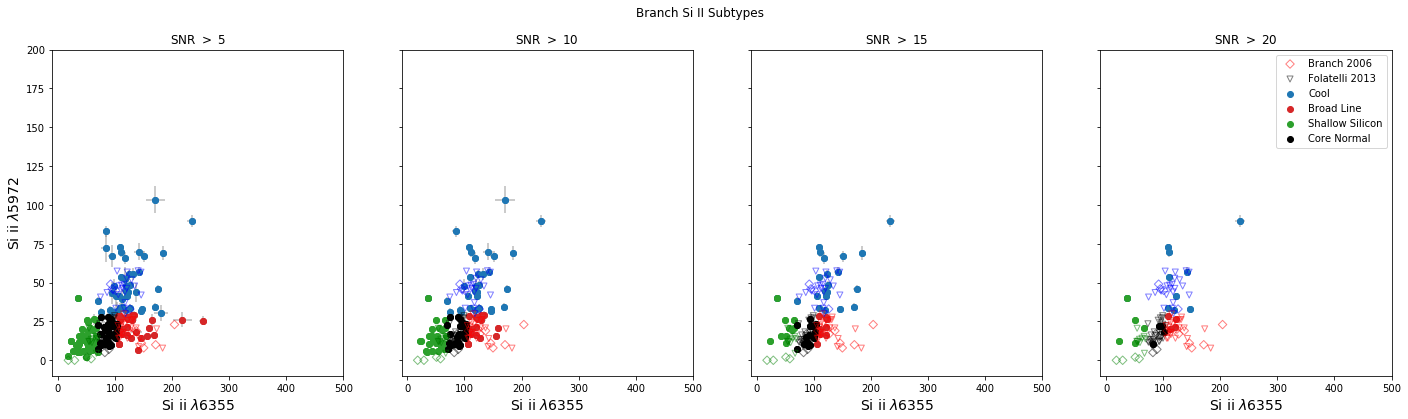

In [20]:
fig, axes = plot_si_ratio(good_spectra, (5, 10, 15, 20))
fig.suptitle(f'Branch Si II Subtypes')
plt.savefig(fig_dir / 'branch_subtypes.pdf')
plt.show()


For curiosity's sake, we investigate the furthest outliers in the first plot.

In [21]:
def get_outliers(spec_data, pw6_cutoff, pw7_cutoff, snr_cutoff=0):
    """Select meaurements with pw6 pew > pw6_cutoff and pw7 pew pw7_cutoff
    
    Args:
        spec_data (DataFrame): Data to select on
        pw6_cutoff    (float): The PEW cutoff for feature pw6
        pw7_cutoff    (float): The PEW cutoff for feature pw7
        snr_cutoff    (float): SNR cutoff to apply before selection
        
    Returns:
        A DataFrame with measurements matching the specified criteria
    """
    good_snr = spec_data[spec_data.pew / spec_data.pew_samperr > snr_cutoff]

    pw6 = good_snr.xs('pW6', level='feat_name')
    outliers = set(pw6[pw6.pew > pw6_cutoff].index)

    pw7 = good_snr.xs('pW7', level='feat_name')
    outliers = list(outliers.intersection(pw7[pw7.pew > pw7_cutoff].index))

    outlier_meas = good_snr.loc[outliers]
    pw6_indices = set(outlier_meas.xs('pW6', level='feat_name').index)
    pw7_indices = set(outlier_meas.xs('pW7', level='feat_name').index)
    outliers = sorted(pw6_indices.intersection(pw7_indices))

    return good_snr.loc[outliers]


In [22]:
outliers = get_outliers(good_spectra, 75, 0)
outliers


,,sid,date,type,feat_start,feat_end,vel,vel_err,vel_samperr,pew,pew_err,pew_samperr,area,area_err,area_samperr,msg,jd,days
obj_id,feat_name,,,,,,,,,,,,,,,,,
19604,pW6,2380,2007-10-31,Ia,5586.144617,5907.164741,0.000000,0.0,0.0,82.980197,0.0,3.737854,3.658505e-16,0.0,2.236807e-17,NaN,2454404.5,-0.3
12136,pW6,563,2005-12-07,Ia,5560.424229,5904.942210,9266.013013,0.0,0.0,103.463717,0.0,8.904945,1.181789e-15,0.0,1.563127e-16,NaN,2453711.5,5.8
6780,pW6,367,2005-11-01,Ia,5603.689582,5896.175082,11257.651855,0.0,0.0,89.694491,0.0,3.980261,6.878165e-16,0.0,4.460173e-17,NaN,2453675.5,6.8
19604,pW7,2380,2007-10-31,Ia,5907.164741,6140.951136,0.000000,0.0,0.0,84.832842,0.0,6.141378,3.433794e-16,0.0,3.582977e-17,NaN,2454404.5,-0.3
12136,pW7,563,2005-12-07,Ia,5901.597375,6359.839738,5644.958041,0.0,0.0,170.722449,0.0,16.915127,1.564937e-15,0.0,2.138153e-16,NaN,2453711.5,5.8
6780,pW7,367,2005-11-01,Ia,5896.175082,6372.401473,10119.968430,0.0,0.0,234.071174,0.0,8.437541,1.520342e-15,0.0,1.049480e-16,NaN,2453675.5,6.8


(<Figure size 1080x864 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x148c64450>,
       dtype=object))

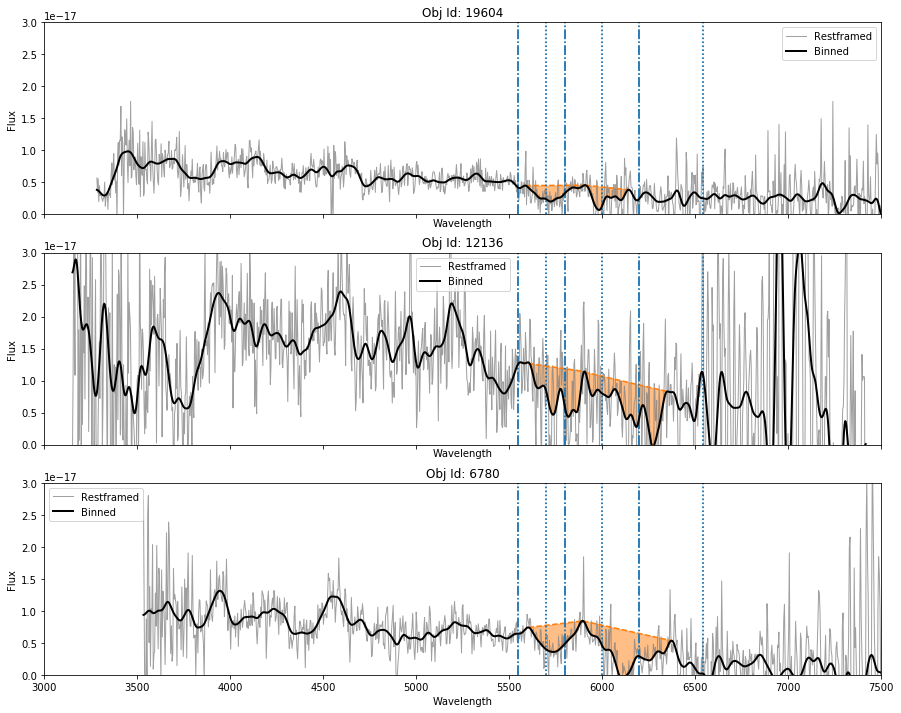

In [23]:
plot_outliers(outliers)


## Photometric Classification <a id='photometric_classification'></a>

With the spectroscopic classifications in hand, we move on to the photometric data.

#### Section Contents:
1. <a href='#exploration_of_failed_fits'>Exploration of Failed Fits</a>: A preliminary exploration of the data.
1. <a href='#classification'>Classification</a>: Classifying photometrically observed targets.
1. <a href='#photometric_vs_spectroscopic'>Photometric V.S. Spectroscopic Classifications</a>: Compares the photometric and spectroscopic results


### Exploration of Failed Fits <a id='exploration_of_failed_fits'></a>

We perform a cursory investigation of any fits that have failed to converge. To start, we note the unique error messages raised in the band and collective fit results.

In [24]:
def get_failed_fits(fits_df):
    """Select failed fits from a dataframe"""
    
    failed_fits = fits_df.message.str.lower().str.contains('failed')
    return fits_df[failed_fits]
    

In [25]:
print('Iminuit band fit error messages:\n')
print(get_failed_fits(iminuit_band_fits).message.unique())

print('\nIminuit collective fit error messages:\n')
print(get_failed_fits(iminuit_coll_fits).message.unique())

print('\nMCMC band fit error messages:\n')
print(get_failed_fits(mcmc_band_fits).message.unique())

print('\nMCMC collective fit error messages:\n')
print(get_failed_fits(mcmc_coll_fits).message.unique())

Iminuit band fit error messages:

['No data points with S/N > 5.0. Initial guessing failed.'
 'Hesse Failed. Covariance may not be accurate. Covariance not positive definite.']

Iminuit collective fit error messages:

['No data points with S/N > 5.0. Initial guessing failed.'
 'Hesse Failed. Covariance may not be accurate. Covariance not positive definite.']

MCMC band fit error messages:

['No data points with S/N > 5.0. Initial guessing failed.']

MCMC collective fit error messages:

['No data points with S/N > 5.0. Initial guessing failed.']


The SNR error is not concerning so long as there are an equal number of occurences between the band and collective fits.

In [26]:
snr_err_msg = 'No data points with S/N > 5.0. Initial guessing failed.'
band_snr_indices = iminuit_band_fits.message == snr_err_msg
collective_snr_indices = iminuit_coll_fits.message == snr_err_msg
equal_errors = sum(band_snr_indices) == sum(collective_snr_indices)

print('Equal Number of SNR errors:', equal_errors)


Equal Number of SNR errors: True


We drop the SNR errors for now and look at the distribution of the remaining errors across bands and models.

In [27]:
iminuit_band_fits_goodsnr = iminuit_band_fits[iminuit_band_fits.message != snr_err_msg]
iminuit_collective_fits_goodsnr = iminuit_coll_fits[iminuit_coll_fits.message != snr_err_msg]


In [28]:
band_failed_nosnr = get_failed_fits(iminuit_band_fits_goodsnr)

print('Band by band error distribution\n')
print('By fitted band (set):')
print(band_failed_nosnr.band.str[-2].value_counts())

print('\nNumber of failed fits per source:')
print(band_failed_nosnr.droplevel(1).index.value_counts())

print('\nNumber of failed fits per object (num_failures number_targets):')
print(band_failed_nosnr.index.value_counts().value_counts())


Band by band error distribution

By fitted band (set):
r    43
z    42
u    40
i    40
g    40
l    36
Name: band, dtype: int64

Number of failed fits per source:
hsiao_x1    240
sn91bg        1
Name: source, dtype: int64

Number of failed fits per object (num_failures number_targets):
6     27
1      6
5      5
11     3
10     1
3      1
2      1
dtype: int64


### Classification <a id='classification'></a>

We apply the classification to the fitted light curves.

In [29]:
def create_border_hist(axis, padding=0):
    """Create axes for plotting border histograms

    Args:
        axis     (Axis): The matplotlib axis to border
        padding (float): Spacing between the main and bordering axes

    Returns:
        Axis for the upper histogram
        Axis for the right side histogram
    """

    axis_pos = axis.get_position()
    axis_width = axis_pos.x1 - axis_pos.x0
    axis_height = axis_pos.y1 - axis_pos.y0

    histx_pos = axis.get_position()
    histx_pos.y0 += axis_height + padding
    histx_pos.y1 = histx_pos.y0 + .35 * axis_height + padding
    histx = plt.axes(histx_pos)
    histx.set_xlim(axis.get_xlim())
    histx.tick_params(direction='in', labelbottom=False)

    histy_pos = axis.get_position()
    histy_pos.x0 += axis_width + padding
    histy_pos.x1 = histy_pos.x0 + .35 * axis_width + padding
    histy = plt.axes(histy_pos)
    histy.set_ylim(axis.get_ylim())
    histy.tick_params(direction='in', labelleft=False)

    return histx, histy


def calc_delta_chisq(fits_df):
    """Calculate the difference in reduces chisq for overall fits

    Args:
        fits_df (DataFrame): Pipeline fit results

    Returns:
        A pandas series
    """

    fits_hsiao = fits_df.loc['hsiao_x1']
    fits_hsiao = fits_hsiao[fits_hsiao.band == 'all']
    fits_sn91bg = fits_df.loc['sn91bg']
    fits_sn91bg = fits_sn91bg[fits_sn91bg.band == 'all']
    return (fits_hsiao.chisq / fits_hsiao.ndof) - (
            fits_sn91bg.chisq / fits_sn91bg.ndof)


def get_sako_pec():
    """Get objects flagged as peculiad in Sako+ 2018"""
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sako_data = sako18.load_table('master').to_pandas(index='CID')

    flagged = sako_data.reindex(sako_data.Notes.dropna().index) 
    flagged = flagged[flagged.Notes > 1]
    return flagged


In [30]:
def plot_chisq_scatter(fits_df):
    """Plot classification results

    Args:
        fits_df (DataFrame): DataFrame of fit results
    """
    
    delta_chi = calc_delta_chisq(fits_df)
    chi_lt0 = delta_chi[delta_chi < 0].index
    chi_gt0 = delta_chi[delta_chi > 0].index

    all_fits =  fits_df[fits_df.band == 'all']
    chisq_hs = all_fits.loc['hsiao_x1'].chisq / all_fits.loc['hsiao_x1'].ndof
    chisq_bg = all_fits.loc['sn91bg'].chisq / all_fits.loc['sn91bg'].ndof
    chisq = pd.DataFrame(dict(chisq_hs=chisq_hs, chisq_bg=chisq_bg))

    fig, axis = plt.subplots(1, 1, figsize=(7 / 2, 7 / 2))
    labels = (r'$\Delta\chi^2 < 0$', r'$\Delta\chi^2 > 0$')
    for index, label in zip((chi_lt0, chi_gt0), labels):
        plot_data = chisq.reindex(index)
        axis.scatter(plot_data.chisq_hs, plot_data.chisq_bg, 
                     s=5, alpha=.2, label=label)

    ylim = axis.get_ylim()
    axis.plot(ylim, ylim, linestyle='--', color='grey')
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.set_xlabel(r'Reduced Hsiao $\chi^2$')
    axis.set_ylabel(r'Reduced SN91bg $\chi^2$')
    axis.legend(framealpha=1)
    return fig, axis


def plot_classification(class_df, fits_df, border_bins, padding):
    """Plot classification results

    Args:
        class_df  (DataFrame): Classification coordinates
        class_df  (DataFrame): Classification results from collective fitting
        fits_df   (DataFrame): DataFrame of fit results
        border_bins (ndarray): Bins for histogram
        padding       (float): Spacing between the main and bordering axes
    """

    fig, axis = plt.subplots(1, 1, figsize=(7 / 2, 7 / 2))
    x_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    y_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    markers = {2: 's', 3: '^', 4: 'o', 5: 'v'}
    labels = {2: '91bg', 3: '00cx', 4: '02ci', 5: '02cx'}

    delta_chi = calc_delta_chisq(fits_df)
    chi_lt0 = delta_chi[delta_chi < 0]
    chi_gt0 = delta_chi[delta_chi > 0]

    sako_pec = get_sako_pec()
    all_data_lt = class_df.reindex(chi_lt0.index).drop(sako_pec.index, errors='ignore')
    all_data_gt = class_df.reindex(chi_gt0.index).drop(sako_pec.index, errors='ignore')
    
    axis.scatter(all_data_lt.x, all_data_lt.y, s=10, alpha=.7)
    axis.scatter(all_data_gt.x, all_data_gt.y, s=10, color='C1', alpha=.7)
    
    axis.axvline(0, color='grey', linestyle='--')
    axis.axhline(0, color='grey', linestyle='--')
    axis.set_xlabel(x_label, fontsize=12, labelpad=10)
    axis.set_ylabel(y_label, fontsize=12)
    axis.set_xlim(min(border_bins), max(border_bins))
    axis.set_ylim(-50, 50)
    
    for flag_type, flag_data in sako_pec.groupby('Notes'):
        plt_data = class_df.reindex(flag_data.index)
        marker = markers[flag_type]
        label = labels[flag_type]
        axis.scatter(plt_data.x, plt_data.y, s=20, 
                     marker=marker, zorder=9,
                     color='k', label=label, facecolor='none')

    histx, histy = create_border_hist(axis, padding)
    histx.hist([all_data_lt.x, all_data_gt.x], bins=border_bins, stacked=True)
    histy.hist([all_data_lt.y, all_data_gt.y], bins=border_bins,
               stacked=True, orientation='horizontal')

    histx.set_xlim(axis.get_xlim())
    histy.set_ylim(axis.get_ylim())
    histx.set_yscale('log')
    histy.set_xscale('log')
    return fig, axis


/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  This is separate from the ipykernel package so we can avoid doing imports until


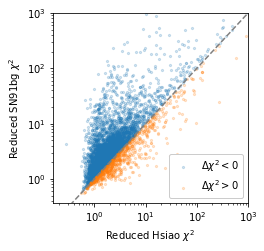

In [31]:
chisq_scat_fig, chisq_scat_axis = plot_chisq_scatter(iminuit_coll_fits)
chisq_scat_axis.set_xlim(0, 1e3)
chisq_scat_axis.set_ylim(0, 1e3)

plt.savefig(fig_dir / 'chisq_scatter.pdf', bbox_inches='tight')
plt.show()


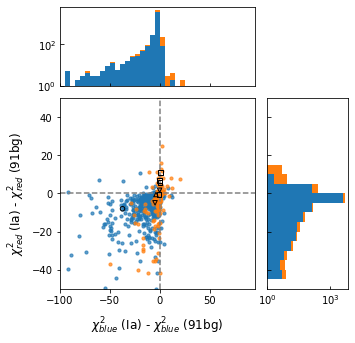

In [32]:
coll_fig, coll_axis = plot_classification(
    class_df=iminuit_band_class, 
    fits_df=iminuit_band_fits, 
    border_bins=np.arange(-100, 100, 5),
    padding=.05
)
    
plt.savefig(fig_dir / 'collective_classification.pdf', bbox_inches='tight')
plt.show()


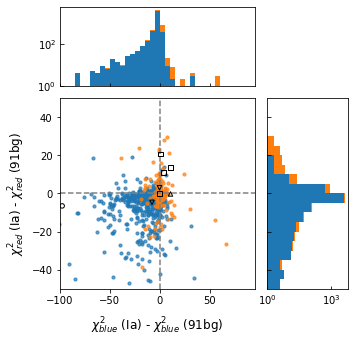

In [33]:
coll_fig, coll_axis = plot_classification(
    class_df=iminuit_coll_class, 
    fits_df=iminuit_coll_fits, 
    border_bins=np.arange(-100, 100, 5),
    padding=.05
)
    
plt.savefig(fig_dir / 'collective_classification.pdf', bbox_inches='tight')
plt.show()


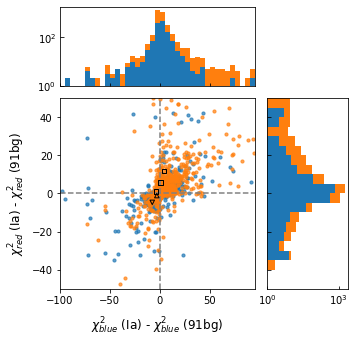

In [34]:
coll_fig, coll_axis = plot_classification(
    class_df=mcmc_band_class, 
    fits_df=mcmc_band_fits, 
    border_bins=np.arange(-100, 100, 5),
    padding=.05
)
    
plt.savefig(fig_dir / 'collective_classification.pdf', bbox_inches='tight')
plt.show()


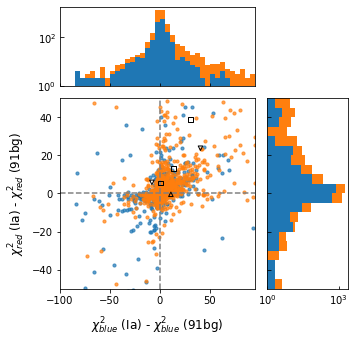

In [35]:
coll_fig, coll_axis = plot_classification(
    class_df=mcmc_coll_class, 
    fits_df=mcmc_coll_fits, 
    border_bins=np.arange(-100, 100, 5),
    padding=.05
)
    
plt.savefig(fig_dir / 'collective_classification.pdf', bbox_inches='tight')
plt.show()


### Photometric V.S. Spectroscopic Classifications <a id='photometric_vs_spectroscopic'></a>

In [36]:
def get_sako_pec():
    """Get objects flagged as peculiad in Sako+ 2018"""
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sako_data = sako18.load_table('master').to_pandas(index='CID')

    flagged = sako_data.reindex(sako_data.Notes.dropna().index) 
    flagged = flagged[flagged.Notes > 1]
    return flagged

pec = get_sako_pec()
pec = pec[pec.Notes == 2.0]
pec

,RA,DEC,Nsearchepoch,IAUName,Classification,Peakrmag,MJDatPeakrmag,NepochSNR5,nSNspec,nGALspec,...,logMassloPEGASE,logMasshiPEGASE,logSFRPEGASE,logSFRloPEGASE,logSFRhiPEGASE,agePEGASE,ageloPEGASE,agehiPEGASE,minchi2PEGASE,Notes
CID,,,,,,,,,,,,,,,,,,,,,
6295,23.672979,-0.605378,10,2005js,SNIa,20.1,53668.3,9,2,1,...,10.77,10.85,-99.0,-99.0,-99.0,4.55,3.81,4.78,10.32,2.0
12979,11.601476,0.003482,6,2006gf,SNIa?,21.1,54047.3,8,1,0,...,11.54,11.79,-99.0,-99.0,-99.0,5.17,4.55,11.00,39.58,2.0
17886,54.006401,1.103365,14,2007jh,SNIa,18.2,54365.5,17,4,0,...,11.11,11.24,-99.0,-99.0,-99.0,5.22,5.02,7.37,60.13,2.0
18890,16.444456,-0.758834,14,2007mm,SNIa,19.3,54394.4,14,2,1,...,10.02,10.03,-99.0,-99.0,-99.0,3.18,3.18,3.18,0.36,2.0


In [37]:
def plot_classification(phot_class, spec_measurements):
    """Plot classification results

    Args:
        class_df  (DataFrame): Classification coordinates
        class_df  (DataFrame): Classification results from collective fitting
    """

    fig, axis = plt.subplots(1, 1, figsize=(7, 7))
    x_label = r'$\chi^2_{blue}$ (Ia) - $\chi^2_{blue}$ (91bg)'
    y_label = r'$\chi^2_{red}$ (Ia) - $\chi^2_{red}$ (91bg)'
    markers = dict(blue='s', red='^', black='o', green='v')
    labels=dict(blue='Cool', red='Broad Line', green='Shallow Silicon', black='Core Normal')

    
    spec_measurements['color'] = get_colors(spec_measurements.pew_pw6, spec_measurements.pew_pw7)
    plot_data = phot_class.join(spec_measurements)    
    
    axis.scatter(plot_data.x, plot_data.y, s=10, alpha=.5, color='grey')
    for color, data in plot_data.groupby('color'):
        axis.scatter(data.x, data.y, s=14, color=color, label=labels[color], marker=markers[color])

    sako_results = phot_class.reindex(pec.index)
    axis.scatter(sako_results.x, sako_results.y, facecolor='none', edgecolor='black', marker='s')

    
    axis.axvline(0, color='grey', linestyle='--')
    axis.axhline(0, color='grey', linestyle='--')
    axis.set_xlabel(x_label, fontsize=12, labelpad=10)
    axis.set_ylabel(y_label, fontsize=12)
    axis.set_xlim(-75, 75)
    axis.set_ylim(-50, 50)
    axis.legend()

    return fig, axis


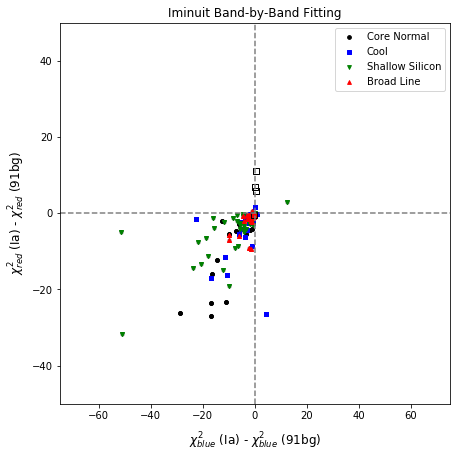

In [38]:
coll_fig, coll_axis = plot_classification(
    phot_class=iminuit_band_class, 
    spec_measurements=get_pew_above_snr(good_spectra, 0)
)

plt.title('Iminuit Band-by-Band Fitting')
plt.show()


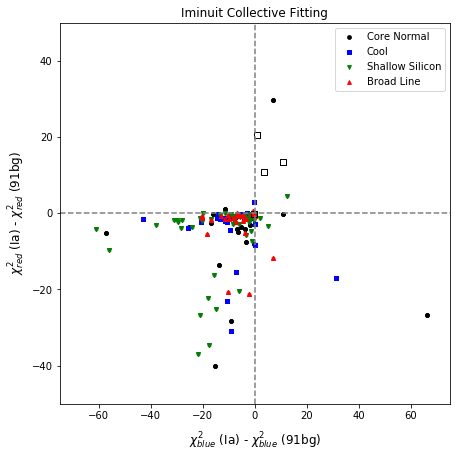

In [39]:
coll_fig, coll_axis = plot_classification(
    phot_class=iminuit_coll_class, 
    spec_measurements=get_pew_above_snr(good_spectra, 0)
)

plt.title('Iminuit Collective Fitting')
plt.show()


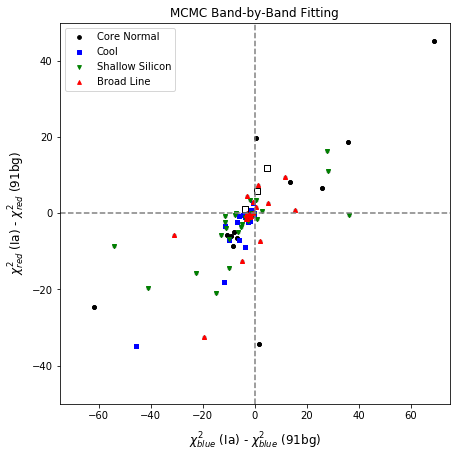

In [40]:
coll_fig, coll_axis = plot_classification(
    phot_class=mcmc_band_class, 
    spec_measurements=get_pew_above_snr(good_spectra, 0)
)

plt.title('MCMC Band-by-Band Fitting')
plt.show()


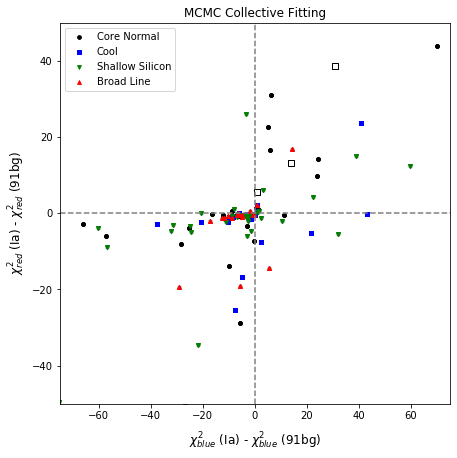

In [41]:
coll_fig, coll_axis = plot_classification(
    phot_class=mcmc_coll_class, 
    spec_measurements=get_pew_above_snr(good_spectra, 0)
)

plt.title('MCMC Collective Fitting')
plt.show()


## Intrinsic Properties <a id='intrinsic_properties'></a>

We consider the distribution of fit parameters.

In [42]:
def plot_param_histogram(fits_df, source, fit_type, param):
    """Plot a histagram of fit parameters
    
    Args:
        fits_df (DataFrame): Fit results
        source        (str): Name of the model to display results for
        fit_type      (str): Use "band" or "collective" fit results
        param         (str): Name of the parameter to plot
    """
    
    # Select data to plot
    fits_using_source = fits_df.loc[source]
    hist_data = fits_using_source[fits_using_source['band'] == 'all'][param]
    
    fig, axis = plt.subplots(1, 1, figsize=(7, 7))
    axis.hist(hist_data, bins=20)
    
    latex_safe_source = source.split("_")[0]
    axis.set_title(param + f' Distribution ({latex_safe_source} - {fit_type} Fits)'.title())
    axis.set_xlabel(param)
    axis.set_ylabel('Combined number of targets')   


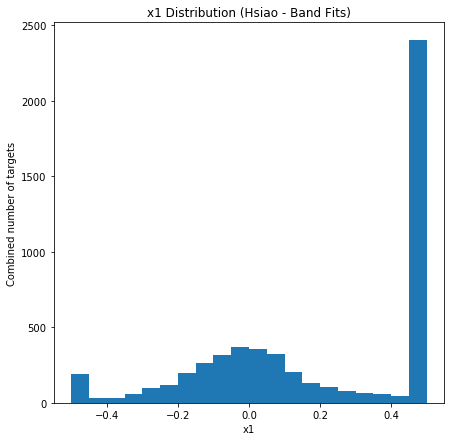

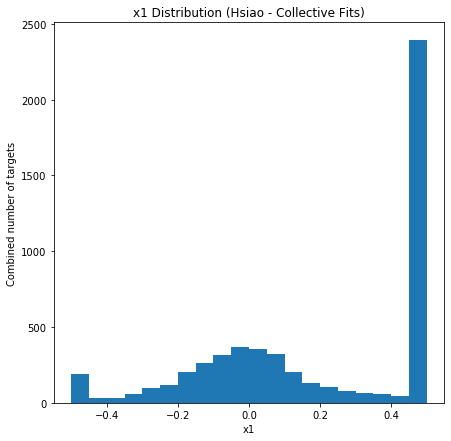

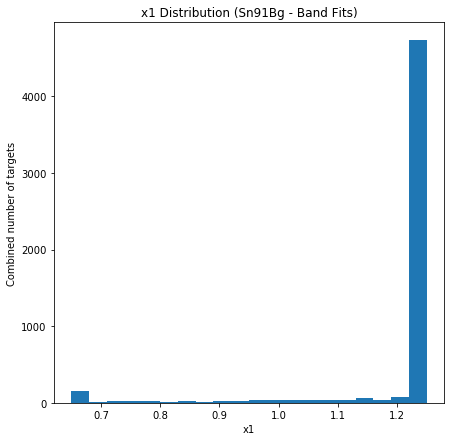

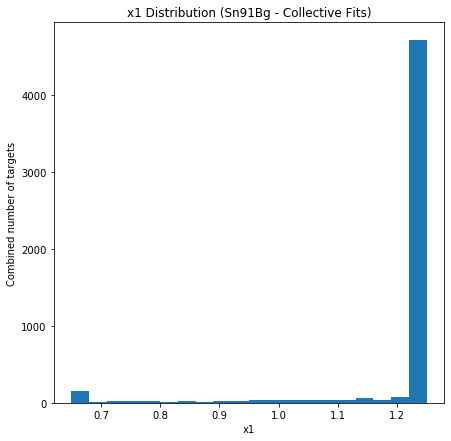

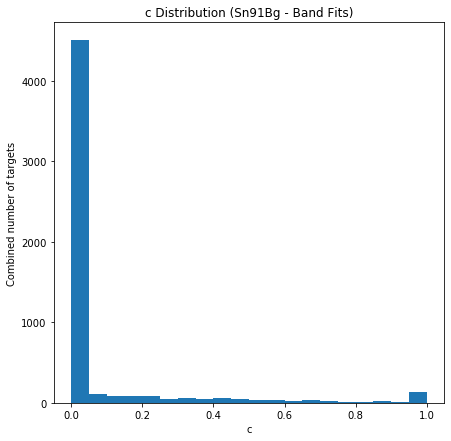

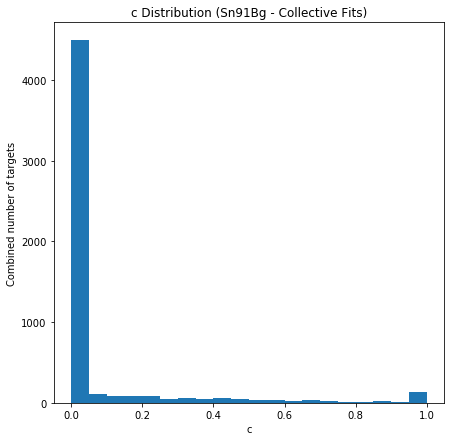

In [43]:
for source in ('hsiao_x1', 'sn91bg'):
    for param in ('x1', 'c'):
        if source == 'hsiao_x1' and param == 'c':
            continue
            
        for fit_type, fit_data in zip(('band', 'collective'), (iminuit_band_fits, iminuit_coll_fits)):
            plot_param_histogram(fit_data, source, fit_type, param)
            plt.savefig(fig_dir / f'{param}_{source}_{fit_type}_fits.pdf'.lower())
            plt.show()


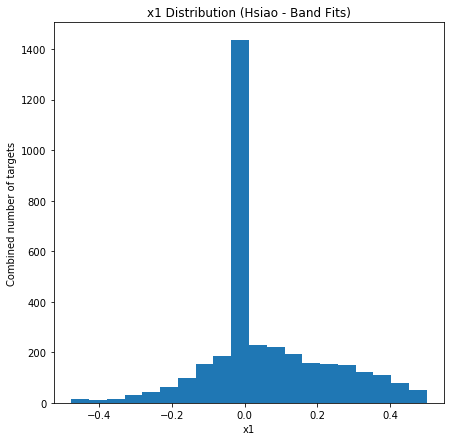

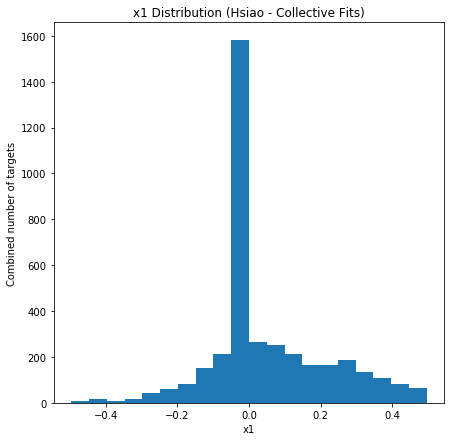

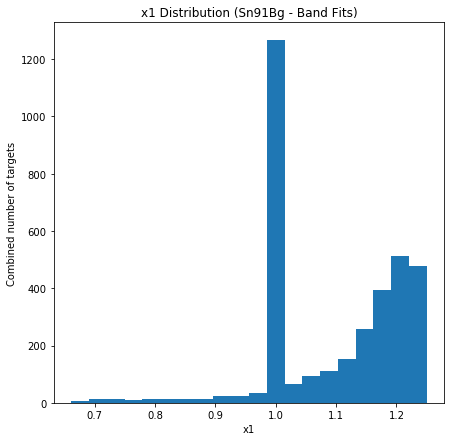

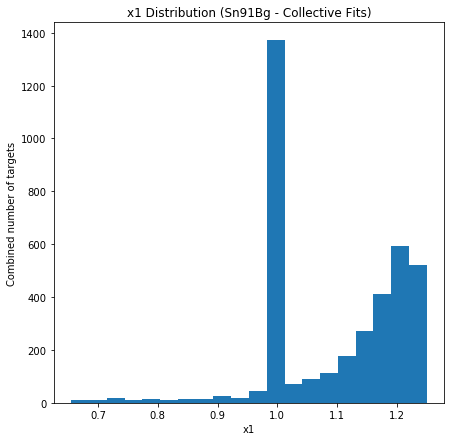

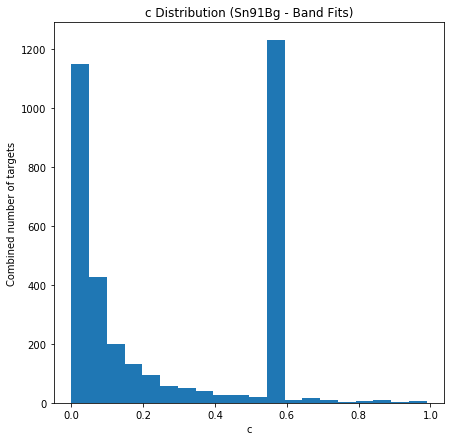

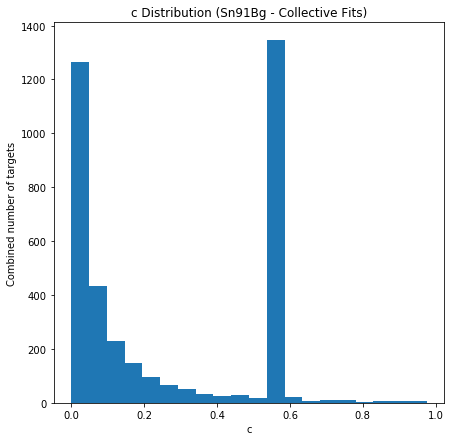

In [44]:
for source in ('hsiao_x1', 'sn91bg'):
    for param in ('x1', 'c'):
        if source == 'hsiao_x1' and param == 'c':
            continue
            
        for fit_type, fit_data in zip(('band', 'collective'), (mcmc_band_fits, mcmc_coll_fits)):
            plot_param_histogram(fit_data, source, fit_type, param)
            plt.savefig(fig_dir / f'{param}_{source}_{fit_type}_fits.pdf'.lower())
            plt.show()


### Host Galaxy Properties <a id='host_properties'></a>

We start with some book keeping and create dataframes for various subsets of the host galaxy data.

In [45]:
host_photometry = pd.DataFrame({
    'obj_id': sdss_master['CID'],
    'host_id': sdss_master['objIDHost'],  # Host galaxy object ID in SDSS DR8 Database 
    'ra': sdss_master['RAhost'],  # Right ascension of galaxy host (degrees) 
    'dec': sdss_master['DEChost'],  # Declination of galaxy host (degrees) 
    'dist': sdss_master['separationhost'], # Distance from SN to host (arcsec) 
    'distnorm': sdss_master['DLRhost'], # Normalized distance from SN to host (dDLR) 
    'z_KF': sdss_master['zphothost'], # Host photometric redshift (KF algorithm) 
    'z_KF_err': sdss_master['zphoterrhost'], # zphothost uncertainty
    'z_RF': sdss_master['zphotRFhost'],  # Host photometric redshift (RF algorithm) 
    'z_RF_err': sdss_master['zphotRFerrhost'],  # zphotRFhost uncertainty 
    'u_mag': sdss_master['dereduhost'],  # Host galaxy u-band magnitude (dereddened) 
    'u_mag_err': sdss_master['erruhost'], # Host galaxy u-band magnitude uncertainty 
    'g_mag': sdss_master['deredghost'],  # Host galaxy g-band magnitude (dereddened)
    'g_mag_err': sdss_master['errghost'],  #  Host galaxy g-band magnitude uncertainty 
    'r_mag': sdss_master['deredrhost'],  # Host galaxy r-band magnitude (dereddened)
    'r_mag_err': sdss_master['errrhost'],  #  Host galaxy r-band magnitude uncertainty 
    'i_mag': sdss_master['deredihost'], # Host galaxy i-band magnitude (dereddened) 
    'i_mag_err': sdss_master['errihost'], # Host galaxy i-band magnitude uncertainty 
    'z_mag': sdss_master['deredzhost'], # Host galaxy z-band magnitude (dereddened) 
    'z_mag_err': sdss_master['errzhost'] # Host galaxy z-band magnitude (dereddened)
})
host_photometry.set_index('obj_id', inplace=True)
    
# Galaxy Parameters Calculated with FSPS
fsps_params = pd.DataFrame({
    'obj_id' : sdss_master['CID'],
    'logmass' : sdss_master['logMassFSPS'],  # FSPS log(M), M=Galaxy Mass (M in units of Me)
    'logmass_lo' : sdss_master['logMassloFSPS'],  # FSPS Lower limit of uncertainty in log(M)
    'logmass_hi' : sdss_master['logMasshiFSPS'],  # FSPS Upper limit of uncertainty in log(M)
    'logssfr' : sdss_master['logSSFRFSPS'],  # FSPS log(sSFR) sSFR=Galaxy Specific Star-forming Rate (SFR in Me yr−1)
    'logssfr_lo' : sdss_master['logSSFRloFSPS'],  # FSPS Lower limit of uncertainty in log(sSFR)
    'logssfr_hi' : sdss_master['logSSFRhiFSPS'],  # FSPS Upper limit of uncertainty in log(sSFR)
    'age' : sdss_master['ageFSPS'],  # FSPS galaxy age (Gyr)
    'age_lo' : sdss_master['ageloFSPS'],  # FSPS Lower limit of uncertainty in age
    'age_hi' : sdss_master['agehiFSPS'],  # FSPS Upper limit of uncertainty in age 
    'rchisq' : sdss_master['minredchi2FSPS'] # Reduced chi-squared of best FSPS template fit
})
fsps_params.set_index('obj_id', inplace=True)

# Galaxy Parameters Calculated with PÉGASE.2
pegase_params = pd.DataFrame({
    'obj_id' : sdss_master['CID'],
    'logmass' : sdss_master['logMassPEGASE'], # PÉGASE.2 log(M), M=Galaxy Mass (M in units of Me) 
    'logmass_lo' : sdss_master['logMassloPEGASE'], # PÉGASE.2 Lower limit of uncertainty in log(M)
    'logmass_hi' : sdss_master['logMasshiPEGASE'], # PÉGASE.2 Upper limit of uncertainty in log(SFR) 
    'logssfr' : sdss_master['logSFRPEGASE'], # PÉGASE.2 log(SFR) SFR=Galaxy star-forming rate (Me yr−1)
    'logssfr_lo' : sdss_master['logSFRloPEGASE'], # PÉGASE.2 Lower limit of uncertainty in log(SFR)
    'logssfr_hi' : sdss_master['logSFRhiPEGASE'], # PÉGASE.2 Upper limit of uncertainty in log(SFR)
    'age' : sdss_master['agePEGASE'], # PÉGASE.2 galaxy age (Gyr)
    'rchisq' : sdss_master['minchi2PEGASE']# Reduced chi-squared of best PÉGASE.2 fit
})
pegase_params.set_index('obj_id', inplace=True)


In [46]:
def plot_host_property_distribution(col_name, bg_ids, normal_ids, *data_frames, **kwargs):
    """Plot histograms of host galaxy properties
    
    Args:
    col_name           (str): The name of the value to plot
    bg_ids          (Series): Object Ids of 91bg like SN
    normal_ids      (Series): Object Ids of normal SN
    *data_frames (DataFrame): Data frames with host galaxy data

    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    fig, axes = plt.subplots(1, len(data_frames), sharex=True, sharey=True)
    if len(data_frames) == 1:
        axes = np.array([axes])
    
    for df, axis in zip(data_frames, axes.flatten()):
        
        plot_data = df[col_name]
        bg_data = plot_data.reindex(bg_ids).dropna()
        normal_data = plot_data.reindex(normal_ids).dropna()
        
        aks = stats.anderson_ksamp([normal_data, bg_data])
        sig_level = aks.significance_level
        
        _, bins, _ = axis.hist(
            normal_data,
            density=True,
            label=f'Normal ({len(normal_data)})', 
            **kwargs
        )
        
        axis.hist(bg_data, 
                  fill=False, 
                  hatch='///', 
                  density=True, 
                  histtype='step', 
                  label=f'91bg ({len(bg_data)})',
                  bins=bins
                 )
        
        title = r'(p $\geq$ 0.25)' if sig_level == 0.25 else f'(p = {sig_level:.2})'
        axis.set_title(title)

    axes[-1].legend()
    plt.tight_layout()
    return fig, axes
        

In [47]:
x_cut = .5
y_cut = 1

bg_like = iminuit_coll_class[(iminuit_coll_class.x > x_cut) & (iminuit_coll_class.y > y_cut)].index
normal = iminuit_coll_class[(iminuit_coll_class.x < x_cut) & (iminuit_coll_class.y < y_cut)].index
print(len(bg_like))


28


/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25


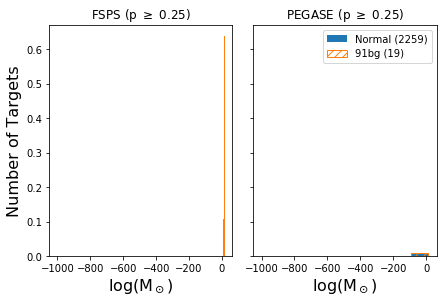

In [48]:
fig, axes = plot_host_property_distribution('logmass', bg_like, normal, fsps_params, pegase_params) 

axes[0].set_ylabel('Number of Targets', fontsize=16)
axes[0].set_title('FSPS ' + axes[0].get_title())
axes[1].set_title('PEGASE ' + axes[1].get_title())
for axis in axes:
    axis.set_xlabel(r'$\log($M$_\odot)$', fontsize=16)
    
plt.savefig(fig_dir / 'collective_fits_mass.pdf', bbox_inches='tight')
plt.show()


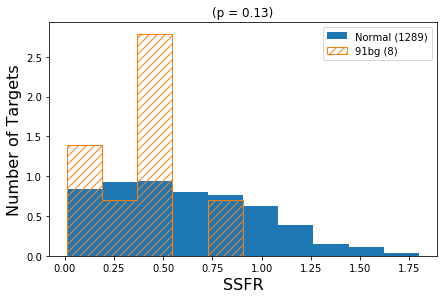

In [49]:
ssfr_data = pegase_params[pegase_params.logssfr > 0]
fig, axes = plot_host_property_distribution('logssfr', bg_like, normal, ssfr_data) 

axes[0].set_xlabel('SSFR', fontsize=16)
axes[0].set_ylabel('Number of Targets', fontsize=16)

plt.savefig(fig_dir / 'collective_fits_ssfr.pdf', bbox_inches='tight')
plt.show()


/anaconda3/envs/phot_class/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: p-value floored: true value smaller than 0.001


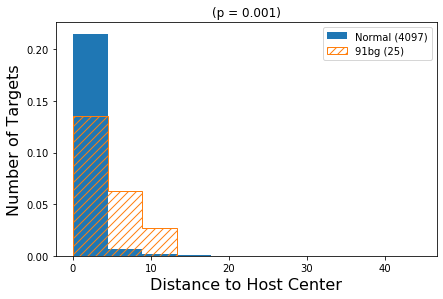

In [50]:
ssfr_data = pegase_params[pegase_params.logssfr > 0]
fig, axes = plot_host_property_distribution('dist', bg_like, normal, host_photometry) 

axes[0].set_xlabel('Distance to Host Center', fontsize=16)
axes[0].set_ylabel('Number of Targets', fontsize=16)

plt.savefig(fig_dir / 'collective_fits_distance.pdf', bbox_inches='tight')
plt.show()


In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_pvalue(class_df, data, max_x=3.5, max_y=3.5, x_cutoff=0, y_cutoff=0, size=30):
    """Plot the p-value for host galaxy data as a function of cutoff value
    
    Args:
        class_df (DataFrame): Classification coordinates
        data        (Series): Host galaxy
        max_x        (float): Maximum for x-axis range
        max_y        (float): Maximum for y-axis range
        x_cutoff     (float): x classification boundary
        y_cutoff     (float): y classification boundary
        size         (float): Number of values to sample in x and y direction
        
    Returns:
        A matplotlib figure
        An array of matplotlib axes
    """
    
    sig_arr = np.zeros((size, size))
    count_arr = np.zeros((size, size))
    x_arr = np.linspace(0, max_x, sig_arr.shape[0])
    y_arr = np.linspace(0, max_y, sig_arr.shape[1])
    
    dx = (x_arr[1] - x_arr[0]) / 2
    dy = (y_arr[1] - y_arr[0]) / 2
    extent = [x_arr[0] - dx, x_arr[-1] + dx, y_arr[0] - dy, y_arr[-1] + dy]

    for i, xcut in enumerate(x_arr):
        for j, ycut in enumerate(y_arr):
            test_bg = class_df[(class_df.x > xcut) & (class_df.y > ycut)].index
            test_normal = class_df[(class_df.x < xcut) & (class_df.y < ycut)].index
            test_bg_data = data.reindex(test_bg).dropna()
            test_normal_data = data.reindex(test_normal).dropna()
            sig = stats.anderson_ksamp([test_normal_data, test_bg_data]).significance_level
            sig_arr[i, j] = sig
            count_arr[i, j] = len(test_bg_data)
    
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(7 / 2, 7))
    for axis, plot_data in zip(axes, (count_arr, sig_arr)):
        divider = make_axes_locatable(axis)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        im = axis.imshow(plot_data, extent=extent, origin='lower')
        fig.colorbar(im, cax=cax, orientation='vertical')
        axis.axvline(x_cutoff, linestyle='--', alpha=.8, color='red')
        axis.axhline(y_cutoff, linestyle='--', alpha=.8, color='red')

    axes[0].set_ylabel('y Cutoff', fontsize=10)
    axes[0].set_title('Number of 91bg points', fontsize=10)
    # axes[0].contour(x_arr, y_arr, count_arr, levels=np.arange(0, 50, 10), colors='red')
    
    axes[1].set_xlabel('x Cutoff', fontsize=10)
    axes[1].set_ylabel('y Cutoff', fontsize=10)
    axes[1].set_title(r'\textit{p}-Value')
    # axes[1].contour(x_arr, y_arr, sig_arr, levels=[0.05], colors='red')
    
    return fig, axes


In [52]:
plot_pvalue(collective_class, fsps_params.logmass, x_cutoff=x_cut, y_cutoff=y_cut) 
plt.tight_layout()
plt.savefig(fig_dir / 'fsps_mass_pvalue.pdf', bbox_inches='tight')
plt.show()

plot_pvalue(collective_class, pegase_params.logmass, x_cutoff=x_cut, y_cutoff=y_cut) 
plt.savefig(fig_dir / 'pegase_mass_pvalue.pdf', bbox_inches='tight')
plt.show()

plot_pvalue(collective_class, ssfr_data.logssfr, x_cutoff=x_cut, y_cutoff=y_cut) 
plt.savefig(fig_dir / 'ssfr_pvalue.pdf', bbox_inches='tight')
plt.show()

plot_pvalue(collective_class, host_photometry.dist, x_cutoff=x_cut, y_cutoff=y_cut) 
plt.savefig(fig_dir / 'dist_pvalue.pdf', bbox_inches='tight')
plt.show()


NameError: name 'collective_class' is not defined